# Extract reactions with multiple enzyme mappings

In [2]:
import cobra
from cobra import io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

### Read in Yeast8 model

In [3]:
model_dir = "yeast-GEM/model"
model_file = next(f for f in os.listdir(model_dir) if f.endswith('.xml'))  # find the first .xml file in the directory
model_path = os.path.join(model_dir, model_file)

# Load the model
model = io.read_sbml_model(model_path)

In [4]:
# Read in the metal annotation file (assuming it has columns 'ORF' and 'term')
metal_annotation_df = pd.read_csv("/Users/aulakhs/Documents/RalserLab/metallica/databases/metal_binding_transport_anno.csv")

# Create a mapping of ORFs to metal annotations
orf_to_term = dict(zip(metal_annotation_df['ORF'], metal_annotation_df['term']))

In [5]:
no_metalanno_color = "#21918c"
metalanno_color = "#440154"

### Extract reactions with multiple ORF mappings

In [6]:
reactions_with_multiple_orfs = {}

for reaction in model.reactions:
    # Using the gene_reaction_rule attribute to get the rule string
    orfs = [gene.id for gene in reaction.genes]
    
    if len(orfs) > 1:
        reactions_with_multiple_orfs[reaction.id] = orfs


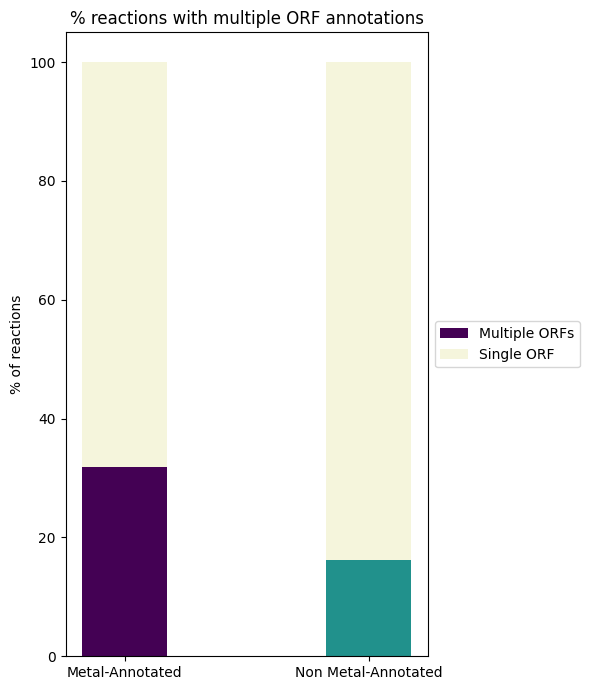

In [7]:
# Classify reactions into metal-annotated and not metal-annotated
metal_annotated_reactions = set()
non_metal_annotated_reactions = set()

for reaction in model.reactions:
    orfs = [gene.id for gene in reaction.genes]
    if any(orf in orf_to_term for orf in orfs):
        metal_annotated_reactions.add(reaction.id)
    else:
        non_metal_annotated_reactions.add(reaction.id)

# Count the reactions with multiple ORFs in both sets
multiple_orf_metal_annotated = sum(1 for reaction in metal_annotated_reactions if len(reactions_with_multiple_orfs.get(reaction, [])) > 1)
multiple_orf_non_metal_annotated = sum(1 for reaction in non_metal_annotated_reactions if len(reactions_with_multiple_orfs.get(reaction, [])) > 1)

# Calculate percentages
percentage_metal_annotated = multiple_orf_metal_annotated / len(metal_annotated_reactions) * 100
percentage_non_metal_annotated = multiple_orf_non_metal_annotated / len(non_metal_annotated_reactions) * 100

# Bar chart
labels = ['Metal-Annotated', 'Non Metal-Annotated']
multiple_orf_percentages = [percentage_metal_annotated, percentage_non_metal_annotated]
single_orf_percentages = [100 - percentage_metal_annotated, 100 - percentage_non_metal_annotated]

bar_width = 0.35
index = range(len(labels))
plt.figure(figsize=(6, 7))
single_orf_color = "beige"

# For simplicity, assuming `index` and `labels` are already defined from earlier steps
bar1 = plt.bar(index, multiple_orf_percentages, bar_width, 
               color=[metalanno_color, no_metalanno_color], label='Multiple ORFs')
bar2 = plt.bar(index, single_orf_percentages, bar_width, 
               bottom=multiple_orf_percentages, color=single_orf_color, label='Single ORF')

plt.xlabel('')
plt.ylabel('% of reactions')
plt.title('% reactions with multiple ORF annotations')
plt.xticks(index, labels)
# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('redundancy_multiORFperc_metal_nometal.pdf', bbox_inches='tight')

plt.show()


In [8]:
percentage_metal_annotated

31.83453237410072

In [9]:
percentage_non_metal_annotated

16.27972027972028

In [10]:
from scipy.stats import chi2_contingency

# Previously calculated values:
a = multiple_orf_metal_annotated
b = len(metal_annotated_reactions) - a
c = multiple_orf_non_metal_annotated
d = len(non_metal_annotated_reactions) - c

# Create the contingency table
contingency_table = [[a, b], [c, d]]

chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("The result is significant at the 0.05 level. There's an association between annotation type and ORF redundancy.")
else:
    print("The result is not significant at the 0.05 level. We can't say there's an association between annotation type and ORF redundancy.")


Chi-squared value: 76.59212927609384
P-value: 2.1017563551286525e-18
The result is significant at the 0.05 level. There's an association between annotation type and ORF redundancy.


## Randomess based control - randomly chose ORFs as metal binding and determine % of nodes that would also have multiple ORFs

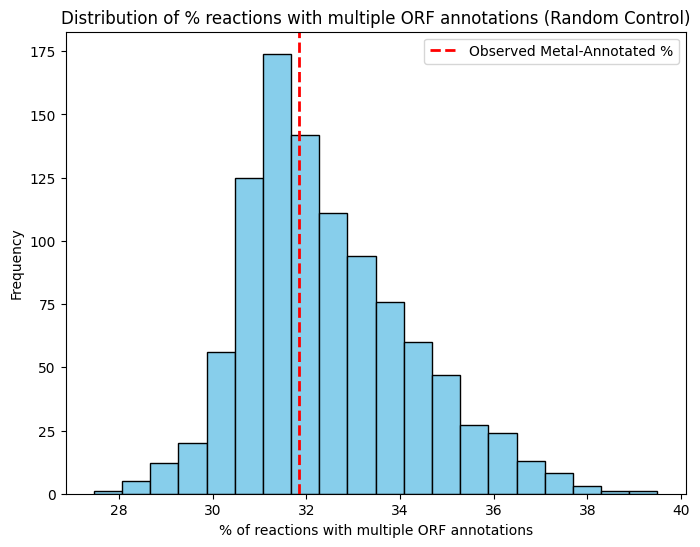

Observed % of metal-annotated reactions with multiple ORFs: 31.83
Mean % from random control: 32.44
Standard deviation from random control: 1.79


In [29]:
# Count the number of unique metal-binding ORFs
metal_binding_orf_count = len(set(orf_to_term.keys()))

# Store the random percentages for each iteration
random_multiple_orf_percentages = []

for _ in range(1000):
    # Randomly select ORFs
    random_orfs = set(random.sample([gene.id for gene in model.genes], metal_binding_orf_count))
    
    # Classify reactions based on the random ORF selection
    random_annotated_reactions = set()
    random_non_annotated_reactions = set()
    
    for reaction in model.reactions:
        orfs = [gene.id for gene in reaction.genes]
        if any(orf in random_orfs for orf in orfs):
            random_annotated_reactions.add(reaction.id)
        else:
            random_non_annotated_reactions.add(reaction.id)
    
    # Count reactions with multiple ORFs in the randomly annotated set
    multiple_orf_random_annotated = sum(1 for reaction in random_annotated_reactions 
                                        if len(reactions_with_multiple_orfs.get(reaction, [])) > 1)
    
    # Calculate the percentage of reactions with multiple ORFs for this random selection
    percentage_random_annotated = multiple_orf_random_annotated / len(random_annotated_reactions) * 100
    random_multiple_orf_percentages.append(percentage_random_annotated)

# Plot the distribution of random percentages
plt.figure(figsize=(8, 6))
plt.hist(random_multiple_orf_percentages, bins=20, color='skyblue', edgecolor='black')
plt.axvline(percentage_metal_annotated, color='red', linestyle='dashed', linewidth=2, label="Observed Metal-Annotated %")
plt.xlabel('% of reactions with multiple ORF annotations')
plt.ylabel('Frequency')
plt.title('Distribution of % reactions with multiple ORF annotations (Random Control)')
plt.legend(loc="upper right")
plt.show()

# Print the observed percentage for metal-annotated reactions and mean of the random distribution for comparison
print(f"Observed % of metal-annotated reactions with multiple ORFs: {percentage_metal_annotated:.2f}")
print(f"Mean % from random control: {np.mean(random_multiple_orf_percentages):.2f}")
print(f"Standard deviation from random control: {np.std(random_multiple_orf_percentages):.2f}")


In [30]:
from scipy.stats import ttest_1samp

# Perform a one-sample t-test comparing the observed percentage to the distribution of random percentages
t_stat, p_value = ttest_1samp(random_multiple_orf_percentages, percentage_metal_annotated)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("The observed percentage is significantly different from the random distribution (p < 0.05).")
else:
    print("The observed percentage is not significantly different from the random distribution (p >= 0.05).")


T-statistic: 10.784820072795169
P-value: 9.946936199625908e-26
The observed percentage is significantly different from the random distribution (p < 0.05).


In [31]:
# Calculate the 95th percentile bounds for the random distribution
lower_bound = np.percentile(random_multiple_orf_percentages, 2.5)
upper_bound = np.percentile(random_multiple_orf_percentages, 97.5)

print(f"95% confidence interval for random distribution: ({lower_bound:.2f}, {upper_bound:.2f})")
print(f"Observed % of metal-annotated reactions with multiple ORFs: {percentage_metal_annotated:.2f}")

# Check if the observed percentage falls outside the 95% confidence interval
if percentage_metal_annotated < lower_bound or percentage_metal_annotated > upper_bound:
    print("The observed percentage falls outside the 95% confidence interval, suggesting a significant difference.")
else:
    print("The observed percentage falls within the 95% confidence interval, suggesting no significant difference.")


95% confidence interval for random distribution: (29.58, 36.49)
Observed % of metal-annotated reactions with multiple ORFs: 31.83
The observed percentage falls within the 95% confidence interval, suggesting no significant difference.


### Check if redundant nodes are changing in the same perturbation 

#### Using differentially abundant proteins along environmental metal concentration

In [10]:
# Read in metal perturbation proteomics results
df = pd.read_csv("/Users/aulakhs/Documents/RalserLab/metallica/experiment_data/metpert_WTproteomics/output/tables/extracellularconc_vs_proteinabundance/lmfit DE res with PQ and SigNotSig AdjPVthresh 0.05 FCthresh 1.5.csv")

In [11]:
from scipy.stats import spearmanr, pearsonr

def correlation_type(spearman_corrs):

    if all([corr > 0 for corr in spearman_corrs]):
        return "always_positive"
    elif all([corr < 0 for corr in spearman_corrs]):
        return "always_negative"
    else:
        return "mixed"


In [12]:
from scipy.stats import spearmanr, pearsonr
import numpy as np
import pandas as pd

# Lists to capture the required data
all_metalrxns_with_multiple_orfs_list = []
tested_reactions_list = []
significant_orfs_list = []
elements_list = []
spearman_correlations = []
pearson_correlations = []
spearman_pvalues = []  
pearson_pvalues = []  
correlation_types = []
tested_rxn_metal_ORFpair_list = []
pearson_directions = []  
spearman_directions = []  
measured_parallel_ORFs = []

# Loop through reactions_with_multiple_orfs
for reaction, orfs in reactions_with_multiple_orfs.items():
    orfs_with_metal_annotation = [orf for orf in orfs if reaction in metal_annotated_reactions]
    
    if len(orfs_with_metal_annotation) > 0:
        all_metalrxns_with_multiple_orfs_list.append(reaction)
    
    temp_pearson_directions = []

    for element in df['Element'].unique():
        orfs_significant = df[(df['Element'] == element) & (df['Significant'] == 1)]['ORF'].tolist()
        
        if any(orf in orfs_significant for orf in orfs_with_metal_annotation):
            significant_orfs_for_reaction = [orf for orf in orfs_with_metal_annotation if orf in orfs_significant]
            
            for significant_orf in significant_orfs_for_reaction:
                for other_orf in orfs:
                    if significant_orf != other_orf and other_orf in df['ORF'].tolist():
                        data_significant = df[(df['ORF'] == significant_orf) & (df['Element'] == element)].set_index('BioSpecID')['Mean_of_reps_Log2FC_vs_AE']
                        data_other = df[(df['ORF'] == other_orf) & (df['Element'] == element)].set_index('BioSpecID')['Mean_of_reps_Log2FC_vs_AE']
                        shared_bio_ids = data_significant.index.intersection(data_other.index)

                        if len(shared_bio_ids) > 4:
                            measured_parallel_ORFs.append(other_orf)
                            tested_reactions_list.append(reaction)
                            significant_orfs_list.append(significant_orf)
                            elements_list.append(element)
                            
                            spearman_coef, spearman_pval = spearmanr(data_significant.loc[shared_bio_ids], data_other.loc[shared_bio_ids], nan_policy='omit')
                            spearman_correlations.append(spearman_coef)
                            spearman_pvalues.append(spearman_pval)

                            valid_mask = ~np.isnan(data_significant.loc[shared_bio_ids]) & ~np.isnan(data_other.loc[shared_bio_ids])
                            data_significant_clean = data_significant.loc[shared_bio_ids][valid_mask]
                            data_other_clean = data_other.loc[shared_bio_ids][valid_mask]
                            pearson_coef, pearson_pval = pearsonr(data_significant_clean, data_other_clean)

                            pearson_correlations.append(pearson_coef)
                            pearson_pvalues.append(pearson_pval)
                            
                            tested_rxn_metal_ORFpair = f"{reaction}_{element}_{significant_orf}_{other_orf}"
                            tested_rxn_metal_ORFpair_list.append(tested_rxn_metal_ORFpair)
                            
                            if (pearson_coef > 0.3) & (pearson_pval < 0.05):
                                pearson_directions.append('positive')
                                temp_pearson_directions.append('positive')
                            elif (pearson_coef < -0.3) & (pearson_pval < 0.05):
                                pearson_directions.append('negative')
                                temp_pearson_directions.append('negative')
                            else:
                                pearson_directions.append('low')
                                temp_pearson_directions.append('low')
                                
                            if (spearman_coef > 0.3) & (spearman_pval < 0.05):
                                spearman_directions.append('positive')
                            elif (spearman_coef < -0.3) & (spearman_pval < 0.05):
                                spearman_directions.append('negative')
                            else:
                                spearman_directions.append('low')
    
    filtered_pearson_directions = [direction for direction in temp_pearson_directions if direction != 'low']
    if all([spearman_directions == 'positive' for direction in filtered_pearson_directions]):
        correlation_type = 'always_positive'
    elif all([spearman_directions == 'negative' for direction in filtered_pearson_directions]):
        correlation_type = 'always_negative'
    else:
        correlation_type = 'mixed'
    
    correlation_types.extend([correlation_type] * len(temp_pearson_directions))


In [13]:
lists_to_check = {
    'Reaction': tested_reactions_list,
    'Significant ORF': significant_orfs_list,
    'Measured Parallel ORF': measured_parallel_ORFs,
    'Element': elements_list,
    'Spearman Correlations': spearman_correlations,
    'Pearson Correlations': pearson_correlations,
    'Spearman pvalues': spearman_pvalues,
    'Pearson pvalues': pearson_pvalues,
    'Correlation Type Across Metals': correlation_types,
    'Pearson Direction': pearson_directions,
    'Spearman Direction': spearman_directions,
    'Reaction Metal ORF Pair': tested_rxn_metal_ORFpair_list
}

for key, value in lists_to_check.items():
    print(f"Length of {key}: {len(value)}")

Length of Reaction: 718
Length of Significant ORF: 718
Length of Measured Parallel ORF: 718
Length of Element: 718
Length of Spearman Correlations: 718
Length of Pearson Correlations: 718
Length of Spearman pvalues: 718
Length of Pearson pvalues: 718
Length of Correlation Type Across Metals: 718
Length of Pearson Direction: 718
Length of Spearman Direction: 718
Length of Reaction Metal ORF Pair: 718


In [14]:
  
result_df = pd.DataFrame({
    'Reaction': tested_reactions_list,
    'Significant ORF': significant_orfs_list,
    'Measured Parallel ORF': measured_parallel_ORFs,
    'Element': elements_list,
    'Spearman Correlations': spearman_correlations,
    'Pearson Correlations': pearson_correlations,
    'Spearman pvalues': spearman_pvalues,
    'Pearson pvalues': pearson_pvalues,
    'Correlation Type Across Metals': correlation_types,
    'Pearson Direction': pearson_directions,
    'Spearman Direction': spearman_directions,
    'Reaction Metal ORF Pair': tested_rxn_metal_ORFpair_list
})

In [15]:
result_df

,Reaction,Significant ORF,Measured Parallel ORF,Element,Spearman Correlations,Pearson Correlations,Spearman pvalues,Pearson pvalues,Correlation Type Across Metals,Pearson Direction,Spearman Direction,Reaction Metal ORF Pair
0,r_0001,YDL174C,YEL071W,Cu,0.703779,0.613254,0.000010,0.000244,mixed,positive,positive,r_0001_Cu_YDL174C_YEL071W
1,r_0001,YEL071W,YDL174C,Fe,-0.044678,0.092402,0.847508,0.690362,mixed,low,low,r_0001_Fe_YEL071W_YDL174C
2,r_0001,YEL071W,YJR048W,Zn,0.471579,0.315345,0.048191,0.202425,mixed,low,positive,r_0001_Zn_YEL071W_YJR048W
3,r_0001,YEL071W,YDL174C,Zn,0.403890,0.721174,0.062300,0.000152,mixed,positive,low,r_0001_Zn_YEL071W_YDL174C
4,r_0001,YDL174C,YEL071W,Zn,0.403890,0.721174,0.062300,0.000152,mixed,positive,low,r_0001_Zn_YDL174C_YEL071W
...,...,...,...,...,...,...,...,...,...,...,...,...
713,r_4672,YMR318C,YDR368W,Zn,0.409611,0.353133,0.058340,0.106943,always_positive,low,low,r_4672_Zn_YMR318C_YDR368W
714,r_4723,YDR452W,YHR201C,Zn,0.797483,0.740469,0.000009,0.000081,mixed,positive,positive,r_4723_Zn_YDR452W_YHR201C
715,r_4724,YDR452W,YHR201C,Zn,0.797483,0.740469,0.000009,0.000081,mixed,positive,positive,r_4724_Zn_YDR452W_YHR201C
716,r_4725,YDR452W,YHR201C,Zn,0.797483,0.740469,0.000009,0.000081,mixed,positive,positive,r_4725_Zn_YDR452W_YHR201C


In [16]:
result_df.to_csv("redundancy_rxns_multipleORF_envDA_correlations.csv")

In [17]:
#### CONTINUE IN R 
#### the results are visualised in R script "plot_metalrxn_multiORF_redundancy.R"

#### Note down hown many unique combinations of enzymes were tested and found to correlate

#### Using differentially abundant proteins along measured cellular metal concentration

In [18]:
# Read in metal perturbation proteomics results 
# Intracellular metal conc vs protein abundance
df = pd.read_csv("/Users/aulakhs/Documents/RalserLab/metallica/experiment_data/metpert_WTproteomics/output/tables/intracellularconc_vs_proteinabundance/lmfit_intracellular_metalconc_vs_log2PQ_with_SigNotSig_AdjPVthresh_0.05_FCthresh_1.5.csv")


In [19]:
df

,Genes,Element,statistic,p.value,ModelTest,Adj.R2.of.Higher.DF,PValAdj_BH,LeastComplexModel,ORF,median_relative_intracellular_concentration,median_log2_protein_abundance,median_log2_foldchangevsAE,MinLog2FC_vs_AE,MaxLog2FC_vs_AE,MaxMag_LogFC,Significant,ModelTest2Keep
0,AAC1,Ca,1.971237,0.134686,3_vs_0,0.066351,0.225212,NaN,YMR056C,1.52,9.065652,1.026332,-1.160893,1.762132,1.762132,0,3_vs_0
1,AAC1,Ca,1.971237,0.134686,3_vs_0,0.066351,0.225212,NaN,YMR056C,0.97,7.702299,-0.337021,-1.160893,1.762132,1.762132,0,3_vs_0
2,AAC1,Ca,1.971237,0.134686,3_vs_0,0.066351,0.225212,NaN,YMR056C,0.65,8.410155,0.370835,-1.160893,1.762132,1.762132,0,3_vs_0
3,AAC1,Ca,1.971237,0.134686,3_vs_0,0.066351,0.225212,NaN,YMR056C,0.82,7.873841,-0.165479,-1.160893,1.762132,1.762132,0,3_vs_0
4,AAC1,Ca,1.971237,0.134686,3_vs_0,0.066351,0.225212,NaN,YMR056C,1.63,8.309123,0.269803,-1.160893,1.762132,1.762132,0,3_vs_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551340,ZWF1,Zn,14.128035,0.000048,2_vs_0,0.450701,0.000203,quadratic,YNL241C,1.31,9.288901,-0.186270,-0.258163,0.460903,0.460903,1,2_vs_0
551341,ZWF1,Zn,14.128035,0.000048,2_vs_0,0.450701,0.000203,quadratic,YNL241C,1.84,9.318369,-0.156803,-0.258163,0.460903,0.460903,1,2_vs_0
551342,ZWF1,Zn,14.128035,0.000048,2_vs_0,0.450701,0.000203,quadratic,YNL241C,2.54,9.217009,-0.258163,-0.258163,0.460903,0.460903,1,2_vs_0
551343,ZWF1,Zn,14.128035,0.000048,2_vs_0,0.450701,0.000203,quadratic,YNL241C,3.09,9.246725,-0.228447,-0.258163,0.460903,0.460903,1,2_vs_0


In [20]:
from scipy.stats import spearmanr, pearsonr
import numpy as np
import pandas as pd

# Lists to capture the required data
all_metalrxns_with_multiple_orfs_list = []
tested_reactions_list = []
significant_orfs_list = []
elements_list = []
spearman_correlations = []
pearson_correlations = []
spearman_pvalues = []  
pearson_pvalues = []  
correlation_types = []
tested_rxn_metal_ORFpair_list = []
pearson_directions = []  
spearman_directions = []  
measured_parallel_ORFs = []

# Loop through reactions_with_multiple_orfs
for reaction, orfs in reactions_with_multiple_orfs.items():
    orfs_with_metal_annotation = [orf for orf in orfs if reaction in metal_annotated_reactions]
    
    if len(orfs_with_metal_annotation) > 0:
        all_metalrxns_with_multiple_orfs_list.append(reaction)
    
    temp_pearson_directions = []

    for element in df['Element'].unique():
        orfs_significant = df[(df['Element'] == element) & (df['Significant'] == 1)]['ORF'].tolist()
        
        if any(orf in orfs_significant for orf in orfs_with_metal_annotation):
            significant_orfs_for_reaction = [orf for orf in orfs_with_metal_annotation if orf in orfs_significant]
            
            for significant_orf in significant_orfs_for_reaction:
                for other_orf in orfs:
                    if significant_orf != other_orf and other_orf in df['ORF'].tolist():
                        data_significant = df[(df['ORF'] == significant_orf) & (df['Element'] == element)].set_index('median_relative_intracellular_concentration')['median_log2_foldchangevsAE']
                        data_other = df[(df['ORF'] == other_orf) & (df['Element'] == element)].set_index('median_relative_intracellular_concentration')['median_log2_foldchangevsAE']
                        shared_bio_ids = data_significant.index.intersection(data_other.index)

                        if len(shared_bio_ids) > 4:
                            measured_parallel_ORFs.append(other_orf)
                            tested_reactions_list.append(reaction)
                            significant_orfs_list.append(significant_orf)
                            elements_list.append(element)
                            
                            spearman_coef, spearman_pval = spearmanr(data_significant.loc[shared_bio_ids], data_other.loc[shared_bio_ids], nan_policy='omit')
                            spearman_correlations.append(spearman_coef)
                            spearman_pvalues.append(spearman_pval)

                            valid_mask = ~np.isnan(data_significant.loc[shared_bio_ids]) & ~np.isnan(data_other.loc[shared_bio_ids])
                            data_significant_clean = data_significant.loc[shared_bio_ids][valid_mask]
                            data_other_clean = data_other.loc[shared_bio_ids][valid_mask]
                            pearson_coef, pearson_pval = pearsonr(data_significant_clean, data_other_clean)

                            pearson_correlations.append(pearson_coef)
                            pearson_pvalues.append(pearson_pval)
                            
                            tested_rxn_metal_ORFpair = f"{reaction}_{element}_{significant_orf}_{other_orf}"
                            tested_rxn_metal_ORFpair_list.append(tested_rxn_metal_ORFpair)
                            
                            if (pearson_coef > 0.3) & (pearson_pval < 0.05):
                                pearson_directions.append('positive')
                                temp_pearson_directions.append('positive')
                            elif (pearson_coef < -0.3) & (pearson_pval < 0.05):
                                pearson_directions.append('negative')
                                temp_pearson_directions.append('negative')
                            else:
                                pearson_directions.append('low')
                                temp_pearson_directions.append('low')
                                
                            if (spearman_coef > 0.3) & (spearman_pval < 0.05):
                                spearman_directions.append('positive')
                            elif (spearman_coef < -0.3) & (spearman_pval < 0.05):
                                spearman_directions.append('negative')
                            else:
                                spearman_directions.append('low')
    
    filtered_pearson_directions = [direction for direction in temp_pearson_directions if direction != 'low']
    if all([spearman_directions == 'positive' for direction in filtered_pearson_directions]):
        correlation_type = 'always_positive'
    elif all([spearman_directions == 'negative' for direction in filtered_pearson_directions]):
        correlation_type = 'always_negative'
    else:
        correlation_type = 'mixed'
    
    correlation_types.extend([correlation_type] * len(temp_pearson_directions))


In [21]:
lists_to_check = {
    'Reaction': tested_reactions_list,
    'Significant ORF': significant_orfs_list,
    'Measured Parallel ORF': measured_parallel_ORFs,
    'Element': elements_list,
    'Spearman Correlations': spearman_correlations,
    'Pearson Correlations': pearson_correlations,
    'Spearman pvalues': spearman_pvalues,
    'Pearson pvalues': pearson_pvalues,
    'Correlation Type Across Metals': correlation_types,
    'Pearson Direction': pearson_directions,
    'Spearman Direction': spearman_directions,
    'Reaction Metal ORF Pair': tested_rxn_metal_ORFpair_list
}

for key, value in lists_to_check.items():
    print(f"Length of {key}: {len(value)}")


Length of Reaction: 944
Length of Significant ORF: 944
Length of Measured Parallel ORF: 944
Length of Element: 944
Length of Spearman Correlations: 944
Length of Pearson Correlations: 944
Length of Spearman pvalues: 944
Length of Pearson pvalues: 944
Length of Correlation Type Across Metals: 944
Length of Pearson Direction: 944
Length of Spearman Direction: 944
Length of Reaction Metal ORF Pair: 944


In [22]:

result_df = pd.DataFrame({
    'Reaction': tested_reactions_list,
    'Significant ORF': significant_orfs_list,
    'Measured Parallel ORF': measured_parallel_ORFs,
    'Element': elements_list,
    'Spearman Correlations': spearman_correlations,
    'Pearson Correlations': pearson_correlations,
    'Spearman pvalues': spearman_pvalues,
    'Pearson pvalues': pearson_pvalues,
    'Correlation Type Across Metals': correlation_types,
    'Pearson Direction': pearson_directions,
    'Spearman Direction': spearman_directions,
    'Reaction Metal ORF Pair': tested_rxn_metal_ORFpair_list
})

In [23]:
result_df.to_csv("redundancy_rxns_multipleORF_cellDA_correlations.csv")

In [24]:
#### CONTINUE IN R 
#### the results are visualised using R script "plot_metalrxn_multiORF_redundancy.R"